Provide your PDB ID and paste here a heatmap representing distances between beta-carbons (CB), consider alpha-carbons when the CB is missing, i.e. for glycine. Provide residue indexes along the axes.

In [39]:
import copy
from Bio.PDB import PDBList, NeighborSearch
from Bio.PDB.PDBParser import PDBParser
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.signal
from collections import defaultdict
import seaborn as sns

PDB_ID = "1jya"
PATH = "./pdb/"

In [40]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(PDB_ID, pdir=PATH, file_format='pdb')

Structure exists: './pdb/pdb1jya.ent' 


'./pdb/pdb1jya.ent'

In [41]:
def get_distance_matrix(structure):
  distances = defaultdict(dict)
  for model in structure:
    for chain in model:
      for residue1 in chain:
        if residue1.has_id('CB'):
          for residue2 in chain:
            if residue2.has_id('CB'):
              distance = residue1['CB'] - residue2['CB']
              distances[residue1.id[1]][residue2.id[1]] = distance
            elif residue2.has_id('CA'):
              distance = residue1['CB'] - residue2['CA']
              distances[residue1.id[1]][residue2.id[1]] = distance

In [42]:
def create_heatmap(distances):
    res_indices = sorted(distances.keys())
    heatmap_data = np.zeros((len(res_indices), len(res_indices)))
    for i, res1 in enumerate(res_indices):
        for j, res2 in enumerate(res_indices):
            if res2 in distances[res1]:
                heatmap_data[i][j] = distances[res1][res2]
            elif res1 in distances[res2]:
                heatmap_data[i][j] = distances[res2][res1]
            else:
                heatmap_data[i][j] = 0
    
    sns.set_theme(style="white")
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(heatmap_data, cmap="coolwarm", square=True, xticklabels=res_indices, yticklabels=res_indices)
    ax.set_xlabel("Residue Index")
    ax.set_ylabel("Residue Index")
    plt.title("Distance Matrix")
    plt.show()

In [43]:
sequence_separation = 6
structure = PDBParser(QUIET=True).get_structure(PDB_ID, PATH + "pdb{}.ent".format(PDB_ID))
distances = get_distance_matrix(structure)
create_heatmap(distances)

AttributeError: 'NoneType' object has no attribute 'keys'

C:\Users\Marco\AppData\Local\Temp\ipykernel_752\3791698428.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap())


TypeError: Image data of dtype object cannot be converted to float

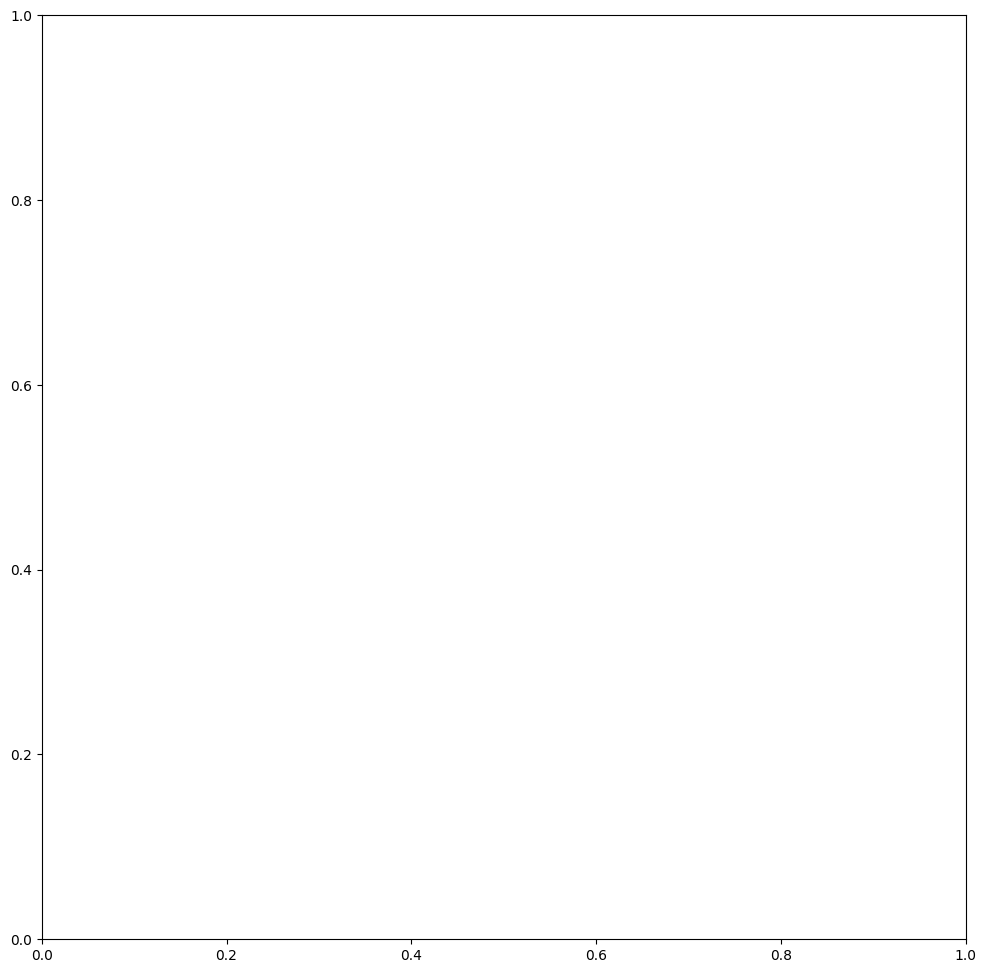

In [28]:
# Plot distance matrix

# Alter the color map to highlight nan values (the diagonal)
current_cmap = copy.copy(matplotlib.cm.get_cmap())
current_cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(dist_matrix)
fig.colorbar(im, fraction=0.03, pad=0.05)
plt.savefig(PATH + '/figures/ca_distances_{}.png'.format(PDB_ID), dpi=300, bbox_inches='tight')